In [ ]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC

In [ ]:
# custom 
import plotting
import dataprocessing

## Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.
#### Important: prière d'exécuter les cellules dans l'ordre ou redémarrer le noyau :) 
### 0. Introduction à git et préparation des données.


In [ ]:
datasets = dataprocessing.load_datasets()

In [ ]:
tpm_data = datasets["ALL"].data
genes = datasets["ALL"].genes
labels = datasets["ALL"].labels
samples = datasets["ALL"].samples

### I. Visualisation avec UMAP

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [41]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Wed Nov 29 17:26:26 2023 Construct fuzzy simplicial set
Wed Nov 29 17:26:26 2023 Finding Nearest Neighbors
Wed Nov 29 17:26:26 2023 Finished Nearest Neighbor Search
Wed Nov 29 17:26:26 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Nov 29 17:26:29 2023 Finished embedding


In [42]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


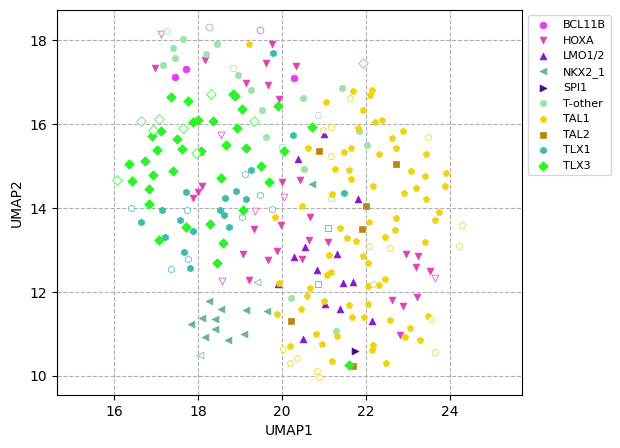

In [66]:
plot_umap(X_tr_umap, X_tst_umap, labels, s = 24)

### II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 
#### 1.A Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>


In [68]:
import torch
from torch import nn

In [ ]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]

#### Exemple d'entrainement de la classification des types de cancer avec 1 fold

In [ ]:
### fonction d'initialisation du reseau
def model(insize, outsize, width=100):
    return nn.Sequential(
    nn.Linear(insize,width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, outsize))

In [ ]:
def train(nepochs = 100, printstep=10, wd = 1e-3):
    DNN = model(insize, outsize)
    optimizer = torch.optim.Adam(DNN.parameters(), lr = 0.0001, weight_decay = wd)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.cross_entropy(y_tr_out, Y_train) # loss computation
        tst_loss = nn.functional.cross_entropy(y_tst_out, Y_test) # Softmax -> NLL
        
        tr_acc = np.array(y_tr_out.max(1).indices == Y_train.max(1).indices,dtype=int).mean() # accuracy metrics
        tst_acc = np.array(y_tst_out.max(1).indices == Y_test.max(1).indices,dtype=int).mean()
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),2)} - acc : {round(float(tr_acc),2)} Test acc : {round(tst_acc,2)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [ ]:
mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 100)

#### Plot learning curves

In [ ]:
steps = np.arange(len(trl))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
axes[0].plot(steps, trl, label = "train")
axes[0].plot(steps, tstl, label= "test")
axes[1].plot(steps, trc * 100, label = "train")
axes[1].plot(steps, tstc * 100, label= "test")
axes[0].set_ylabel("CrossEntropyLoss")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim((0,100))
axes[1].set_xlabel("Gradient step")
axes[0].legend()
axes[0].set_title(f"Learning curves of DNN on classification of cancer type in TCGA data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")
plt.savefig("DNN_learning_curves.pdf")

#### Plot final accuracy with confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_tr_out = np.array(mm(X_train).max(1).indices)
y_tr_true = np.array(Y_train.max(1).indices)
y_tst_out = np.array([np.unique(labels)[x] for x in mm(X_test).max(1).indices])
y_tst_true = np.array([np.unique(labels)[x] for x in Y_test.max(1).indices])
cm = confusion_matrix(y_tst_true, y_tst_out, labels =  np.unique(labels))
print(f"Accuracy on train set (n = {X_train.shape[0]}): {round((np.mean( y_tr_out== y_tr_true)),4) * 100}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {round((np.mean(y_tst_out == y_tst_true)),4) * 100}%")
print(f"Number of errors : {(np.sum(y_tst_out != y_tst_true)) }")


In [ ]:
import seaborn as sn
import itertools

In [ ]:
#df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (10,10))
ax = plt.imshow(cm, interpolation = "nearest", cmap = plt.get_cmap('Blues'))
#ax.set_ylim(0, 3) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
#ax.invert_yaxis() #optional
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        
tick_marks = np.arange(len(np.unique(labels)))
plt.xticks(tick_marks, np.unique(labels), rotation=45)
plt.yticks(tick_marks, np.unique(labels))
plt.title(f"Classifier DNN confusion matrix results on TCGA Test set nb errors")
plt.savefig("DNN_TEST_CM.pdf")

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
log_clf = RidgeClassifier(alpha = 1e-4, solver = "lsqr", max_iter = 100)
log_clf.fit(X_train, Y_train)

In [ ]:
print(f"Accuracy on train set (n = {X_train.shape[0]}): {round((np.mean(log_clf.predict(X_train) == Y_train)),4) * 100}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {round((np.mean(log_clf.predict(X_test) == Y_test)),4) * 100}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")


In [ ]:
y_tst_out = log_clf.predict(X_test)
y_tst_true = Y_test
cm = confusion_matrix(y_tst_true, y_tst_out, labels =  np.unique(labels))
#df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (10,10))
ax = plt.imshow(cm, interpolation = "nearest", cmap = plt.get_cmap('Blues'))
#ax.set_ylim(0, 3) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
#ax.invert_yaxis() #optional
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        
tick_marks = np.arange(len(np.unique(labels)))
plt.xticks(tick_marks, np.unique(labels), rotation=45)
plt.yticks(tick_marks, np.unique(labels))
plt.savefig("LOG_CLF_TEST_CM.pdf")

## III. Classification de sous-types de cancers du sein et comparaison de methodes entre la regression logistique regularisee et un modele d'apprentissage profond.

In [ ]:
# importation des donnees
dataset = h5py.File("TCGA_BRCA_fpkm_hv_norm_PAM50.h5","r")
tpm_data = dataset['data'][:,:] 
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str)

In [ ]:
tsne = TSNE(verbose = 5, init = 'pca', n_iter = 2000)
X_tr_tsne = tsne.fit_transform(tpm_data.T)

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.grid(visible=True,linestyle="--")
ax1.set_axisbelow(True)
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
for (i,lbl) in enumerate(np.unique(labels)):
    #defin_ = tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0] 
    #count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
    #tag = f"{defin_} ({count_})"
    #print(X_tr_tsne[labels ==lbl,0])
    ax1.scatter(X_tr_tsne[labels ==lbl,0], 
                X_tr_tsne[labels ==lbl,1], 
                s = 8, marker=markers_[i], label = lbl)
ax1.axis("equal")
ax1.legend(bbox_to_anchor=(1,1),fontsize = 8)
ax1.set_xlabel("TSNE1")
ax1.set_ylabel("TSNE2")
plt.tight_layout()
plt.savefig("figTSNE.pdf")

In [ ]:

# classification avec RidgeClassifier
logclf_acc,nb_rep = [],50
for i in range(nb_rep):
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
    log_clf = RidgeClassifier(alpha = 1e-3, solver = "lsqr", max_iter = 1000)
    log_clf.fit(X_train, Y_train)
    logclf_acc.append(np.mean(log_clf.predict(X_test) == Y_test))

print(f"Accuracy on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(logclf_acc)),4) * 100} +/- {round(np.std(logclf_acc),4)} %")


In [ ]:
# classification avec DNN
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]
dnnclf_acc,nb_rep = [],10
for i in range(nb_rep):
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 1000, wd = 1e-2)
    dnnclf_acc.append(tstc[-1])
print(f"Accuracy DNN on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(dnnclf_acc)) * 100,2) } +/- {round(np.std(dnnclf_acc) * 100,2)} %")


In [ ]:
# importation des donnees
dataset = h5py.File("TARGET_ALL_264_norm_tpm_lab.h5","r")
tpm_data = dataset['data'][:,:] 
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str)

In [ ]:
tpm_data.shape

In [ ]:
tsne = TSNE(init = "pca", perplexity =20, n_iter = 2000)
X_tr_tsne = tsne.fit_transform(tpm_data.T)

In [ ]:
import plotting
plotting.plot_tsne(X_tr_tsne, labels)

In [ ]:
# classification avec RidgeClassifier
logclf_acc,nb_rep = [],50
for i in range(nb_rep):
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
    log_clf = RidgeClassifier(alpha = 1e-3, solver = "lsqr", max_iter = 1000)
    log_clf.fit(X_train, Y_train)
    logclf_acc.append(np.mean(log_clf.predict(X_test) == Y_test))

print(f"Accuracy on test set \n(nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(logclf_acc)),4) * 100} +/- {round(np.std(logclf_acc),4)} %")


In [ ]:
import torch
import torch.nn as nn

In [ ]:
# classification avec DNN
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]
dnnclf_acc,nb_rep = [],10
for i in range(nb_rep):
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 1000, wd = 1e-2)
    dnnclf_acc.append(tstc[-1])
print(f"Accuracy DNN on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(dnnclf_acc)) * 100,2) } +/- {round(np.std(dnnclf_acc) * 100,2)} %")


### I. 